In [1]:
# Add project root so we can import from src/
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)
print("src exists:", (PROJECT_ROOT / "src").exists())





Project root: C:\Users\simon\Desktop\Python\Projects\XVA_CVA_SWAP
src exists: True


In [2]:
from src.rates_model import simulate_vasicek
print("Import successful")





Import successful


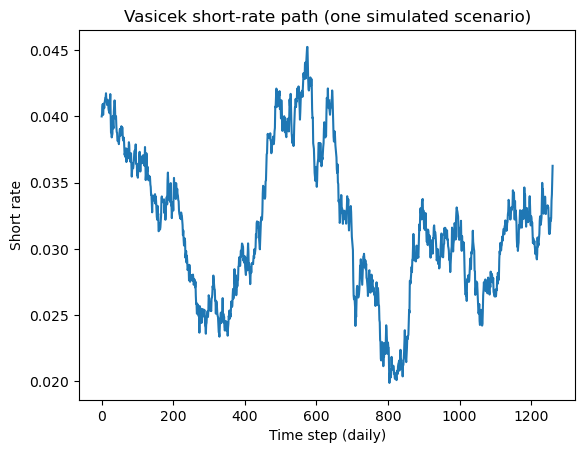

min rate: 0.01988016053479647
max rate: 0.04524768694026048
start: 0.04 end: 0.03627069875659055


In [3]:
import matplotlib.pyplot as plt
from src.rates_model import simulate_vasicek

# --- 1) Choose a time grid for the simulation ---
# dt is the time step in YEARS.
# 1/252 is a common convention for "1 business day" in finance.
dt = 1/252

# We want to simulate rates out to a 5-year horizon (matches a typical swap maturity).
years = 5

# Number of discrete steps on the grid.
# Example: 5 years * 252 steps/year = 1260 steps.
n_steps = int(years / dt)

# --- 2) Set Vasicek model parameters ---
# r0: starting short rate (today)
# kappa: mean reversion speed (how strongly rates are pulled back toward theta)
# theta: long-run average rate (the level rates revert toward)
# sigma: volatility (how noisy day-to-day moves are)
# seed: makes the random path reproducible for debugging (same seed => same path)
r = simulate_vasicek(
    r0=0.04,
    kappa=0.8,
    theta=0.04,
    sigma=0.01,
    dt=dt,
    n_steps=n_steps,
    seed=1
)

# --- 3) Plot the simulated path ---
# This plot is a sanity check that the model behaves sensibly:
# it should wander around theta and not explode.
plt.plot(r)
plt.title("Vasicek short-rate path (one simulated scenario)")
plt.xlabel("Time step (daily)")
plt.ylabel("Short rate")
plt.show()

# --- 4) Quick numerical sanity checks ---
# This helps confirm outputs are in a reasonable range.
print("min rate:", r.min())
print("max rate:", r.max())
print("start:", r[0], "end:", r[-1])


Shape (paths, time): (2000, 1261)


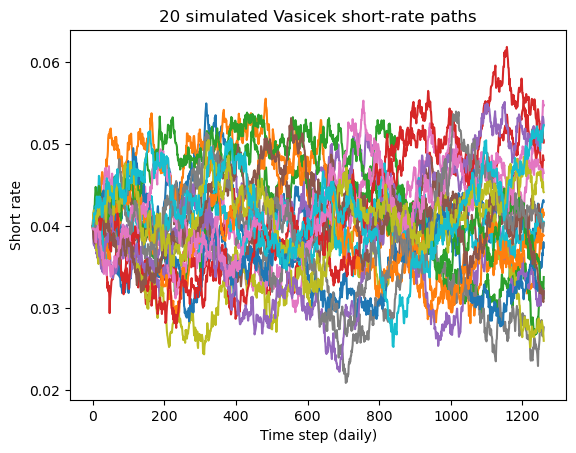

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from src.rates_model import simulate_vasicek_paths

# --- 1) Define the simulation grid ---
# Time step in years (1 business day).
dt = 1 / 252

# Total simulation horizon in years.
# Five years is typical for medium-dated swaps.
years = 5

# Number of discrete time steps on the grid.
# Example: 5 years * 252 days/year = 1260 steps.
n_steps = int(years / dt)

# Number of Monte Carlo scenarios.
# Each path represents one possible future interest-rate world.
n_paths = 2000

# --- 2) Simulate short-rate paths ---
# Output shape is (n_paths, n_steps + 1)
# Rows   = different simulated futures
# Columns = time evolution along each future
r_paths = simulate_vasicek_paths(
    r0=0.04,      # today's short rate
    kappa=0.8,    # speed of mean reversion
    theta=0.04,   # long-run mean rate
    sigma=0.01,   # volatility
    dt=dt,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=1        # fixed seed for reproducibility
)

# Confirm dimensions are as expected.
# This is a critical sanity check in Monte Carlo work.
print("Shape (paths, time):", r_paths.shape)

# --- 3) Plot a small subset of paths ---
# Plotting all 2000 paths would be unreadable.
# Instead, we randomly select 20 representative scenarios.
idx = np.random.default_rng(0).choice(n_paths, size=20, replace=False)

plt.figure()
plt.plot(r_paths[idx].T)  # transpose so time is on the x-axis
plt.title("20 simulated Vasicek short-rate paths")
plt.xlabel("Time step (daily)")
plt.ylabel("Short rate")
plt.show()


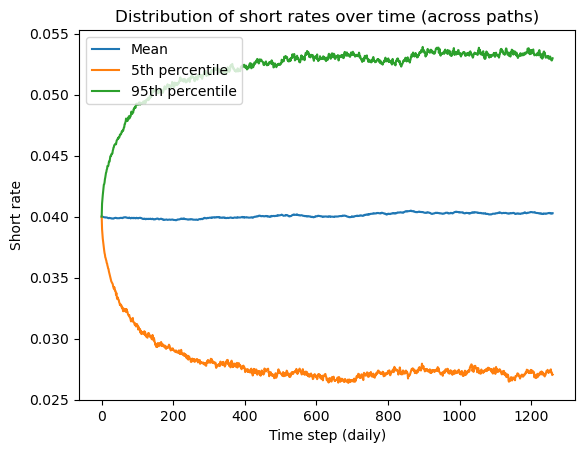

In [5]:
# --- 4) Summarize the distribution across paths ---
# At each time t, we now look across all simulated paths.

# Mean short rate at each future time.
# This represents the expected rate path.
mean = r_paths.mean(axis=0)

# Lower tail of the distribution.
# 5th percentile means "only 5% of scenarios are below this level".
p5 = np.percentile(r_paths, 5, axis=0)

# Upper tail of the distribution.
# 95th percentile means "only 5% of scenarios are above this level".
p95 = np.percentile(r_paths, 95, axis=0)

# --- 5) Plot distribution statistics ---
# This plot shows how uncertainty evolves over time.
plt.figure()
plt.plot(mean, label="Mean")
plt.plot(p5, label="5th percentile")
plt.plot(p95, label="95th percentile")
plt.title("Distribution of short rates over time (across paths)")
plt.xlabel("Time step (daily)")
plt.ylabel("Short rate")
plt.legend()
plt.show()



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from src.rates_model import simulate_vasicek_paths
from src.curve import discount_factors_from_short_rates

dt = 1/252
years = 5
n_steps = int(years / dt)
n_paths = 2000

r_paths = simulate_vasicek_paths(
    r0=0.04, kappa=0.8, theta=0.04, sigma=0.01,
    dt=dt, n_steps=n_steps, n_paths=n_paths, seed=1
)

df_paths = discount_factors_from_short_rates(r_paths, dt)

print("r_paths shape:", r_paths.shape)
print("df_paths shape:", df_paths.shape)

# Discount factors should start at 1 and generally decline over time
print("DF at t=0 (first 5 paths):", df_paths[:5, 0])
print("DF at final time (first 5 paths):", df_paths[:5, -1])


r_paths shape: (2000, 1261)
df_paths shape: (2000, 1261)
DF at t=0 (first 5 paths): [1. 1. 1. 1. 1.]
DF at final time (first 5 paths): [0.85427574 0.79685153 0.82308147 0.81166201 0.80589885]


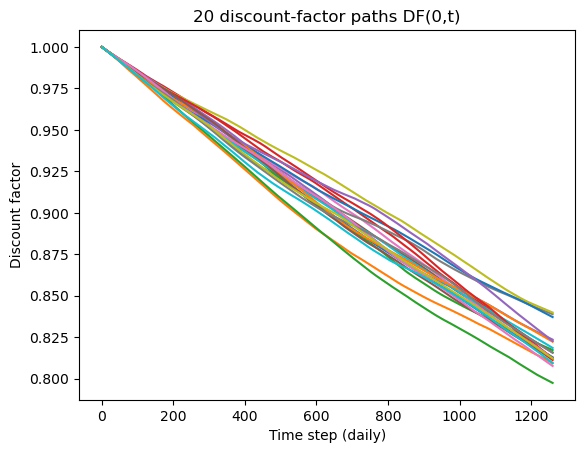

In [7]:
# --- 1) Plot a subset of discount-factor paths ---
# Each DF path corresponds to one simulated interest-rate scenario.
# Plotting all 2000 would be unreadable, so we randomly select 20.

idx = np.random.default_rng(0).choice(n_paths, size=20, replace=False)

plt.figure()

# We transpose so that:
#   x-axis = time
#   each line = one Monte Carlo path
plt.plot(df_paths[idx].T)

plt.title("20 discount-factor paths DF(0,t)")
plt.xlabel("Time step (daily)")
plt.ylabel("Discount factor")
plt.show()


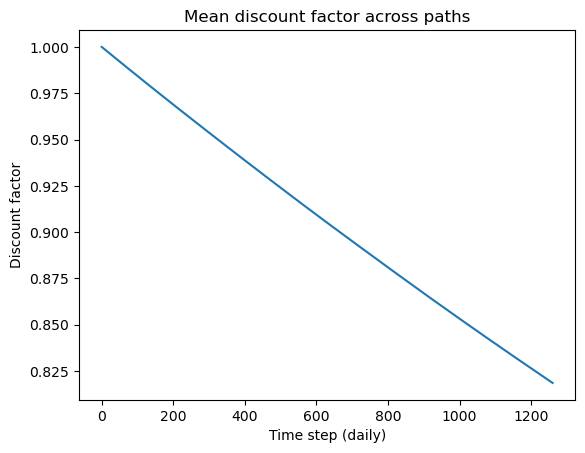

In [8]:
# --- 2) Compute and plot the mean discount factor ---
# This is the expected discount factor at each future time.
# It is the Monte Carlo average across all rate scenarios.

mean_df = df_paths.mean(axis=0)

plt.figure()
plt.plot(mean_df)

plt.title("Mean discount factor across paths")
plt.xlabel("Time step (daily)")
plt.ylabel("Discount factor")
plt.show()


In [9]:
# --- Price a simple fixed cashflow at maturity ---
# Cashflow: 1 unit paid at final time T

cashflow = 1.0
pv_paths = cashflow * df_paths[:, -1]

print("PV stats:")
print("mean PV:", pv_paths.mean())
print("min PV:", pv_paths.min())
print("max PV:", pv_paths.max())


PV stats:
mean PV: 0.8185878118023354
min PV: 0.7593015759408428
max PV: 0.8843786806371701


In [10]:
# --- Price a fixed leg with annual payments ---
# This mimics the fixed leg of a vanilla interest rate swap.

notional = 1.0
fixed_rate = 0.04
payment_times_years = np.arange(1, years + 1)  # [1, 2, 3, 4, 5]

# Convert payment times (in years) to indices on the daily grid
payment_indices = (payment_times_years / dt).astype(int)

# Fixed cashflow per payment date
fixed_cashflow = notional * fixed_rate

# Pathwise PV of the fixed leg
# For each path, sum discounted fixed payments
pv_fixed_paths = np.zeros(n_paths)

for idx in payment_indices:
    pv_fixed_paths += fixed_cashflow * df_paths[:, idx]

print("Fixed leg PV stats:")
print("mean PV:", pv_fixed_paths.mean())
print("min PV:", pv_fixed_paths.min())
print("max PV:", pv_fixed_paths.max())


Fixed leg PV stats:
mean PV: 0.17768983593154622
min PV: 0.17027330740025787
max PV: 0.1865950447211953


In [11]:
# --- Floating leg PV approximation (par floater starting today) ---
# For a standard floating leg that resets to par, the PV at time 0 is approximately:
#   PV_float = N * (1 - DF(0,T))
# Intuition: a par floater is like holding a bond that always resets to par.

notional = 1.0
df_T = df_paths[:, -1]                 # DF(0,T) for each path
pv_float_paths = notional * (1.0 - df_T)

print("Floating leg PV stats:")
print("mean PV:", pv_float_paths.mean())
print("min PV:", pv_float_paths.min())
print("max PV:", pv_float_paths.max())


Floating leg PV stats:
mean PV: 0.18141218819766464
min PV: 0.11562131936282993
max PV: 0.2406984240591572


In [12]:
# --- Swap PV at time 0 (pay fixed, receive float) ---
# PV_swap = PV_float - PV_fixed
# Positive PV means the swap is an asset to us in that scenario.

pv_swap_paths = pv_float_paths - pv_fixed_paths

print("Swap PV stats (time 0):")
print("mean PV:", pv_swap_paths.mean())
print("min PV:", pv_swap_paths.min())
print("max PV:", pv_swap_paths.max())


Swap PV stats (time 0):
mean PV: 0.0037223522661184163
min PV: -0.07097372535836538
max PV: 0.07042511665889933


In [13]:
# --- Exposure definition at time 0 ---
# Exposure is only the positive part, because if we owe them money (negative PV),
# we are not exposed to their default on that amount.
exposure_0 = np.maximum(pv_swap_paths, 0.0)

print("Exposure stats (time 0):")
print("mean exposure:", exposure_0.mean())
print("fraction positive:", (pv_swap_paths > 0).mean())


Exposure stats (time 0):
mean exposure: 0.010214865743509556
fraction positive: 0.587


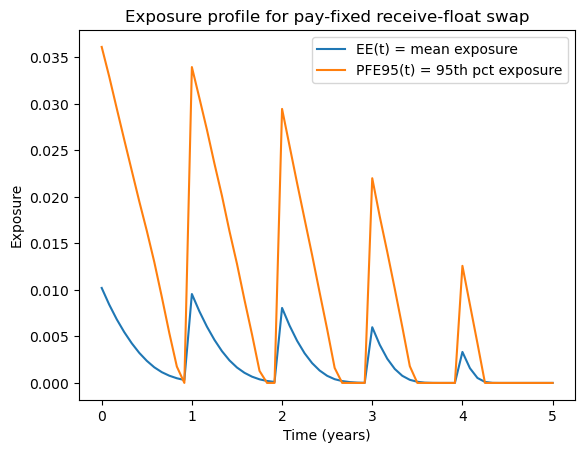

EE at t=0: 0.010214865743509556
EE at final time (should be ~0): 0.0


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- Exposure profile EE(t) for a pay-fixed, receive-float swap ---

# We already have:
#   df_paths: shape (n_paths, n_steps+1) with DF(0,t) for each path and time
#   n_paths, n_steps, dt, years
#   pv_fixed_paths at time 0 computed earlier (not required here)

# Swap definition (same as before)
notional = 1.0
fixed_rate = 0.04
fixed_cashflow = notional * fixed_rate  # annual coupon payment, simplified accrual

# Payment times for the fixed leg (annual)
payment_times_years = np.arange(1, years + 1)              # [1,2,3,4,5]
payment_indices = (payment_times_years / dt).astype(int)   # grid indices: [252,504,...]

# Choose evaluation times for exposure.
# Daily EE is possible, but monthly is clearer and faster.
eval_step = 21  # roughly 1 month of business days
eval_indices = np.arange(0, n_steps + 1, eval_step)

# Containers for exposure statistics over time
EE = np.zeros(len(eval_indices))     # Expected Exposure = mean(max(PV,0))
PFE95 = np.zeros(len(eval_indices))  # 95th percentile of exposure (optional but useful)

for k, t_idx in enumerate(eval_indices):
    # DF(0,t) for each path (vector length n_paths)
    df_0_t = df_paths[:, t_idx]

    # --- 1) Floating leg PV at time t (par floater approximation) ---
    # PV_float(t) ≈ N * (1 - DF(t,T))
    # DF(t,T) = DF(0,T) / DF(0,t) path-by-path
    df_t_T = df_paths[:, -1] / df_0_t
    pv_float_t = notional * (1.0 - df_t_T)

    # --- 2) Fixed leg PV at time t (remaining payments only) ---
    # PV_fixed(t) = sum_{pay dates > t} fixed_cashflow * DF(t, pay_date)
    pv_fixed_t = np.zeros(n_paths)

    for pay_idx in payment_indices:
        if pay_idx > t_idx:
            df_t_pay = df_paths[:, pay_idx] / df_0_t  # DF(t, pay) = DF(0,pay)/DF(0,t)
            pv_fixed_t += fixed_cashflow * df_t_pay

    # --- 3) Swap PV at time t (pay fixed, receive float) ---
    pv_swap_t = pv_float_t - pv_fixed_t

    # --- 4) Exposure at time t ---
    # Exposure is the positive part only
    exposure_t = np.maximum(pv_swap_t, 0.0)

    # Store summary stats across paths
    EE[k] = exposure_t.mean()
    PFE95[k] = np.percentile(exposure_t, 95)

# Convert evaluation indices to years for plotting
eval_times_years = eval_indices * dt

# --- Plot EE(t) and PFE95(t) ---
plt.figure()
plt.plot(eval_times_years, EE, label="EE(t) = mean exposure")
plt.plot(eval_times_years, PFE95, label="PFE95(t) = 95th pct exposure")
plt.title("Exposure profile for pay-fixed receive-float swap")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")
plt.legend()
plt.show()

# Print a quick checkpoint
print("EE at t=0:", EE[0])
print("EE at final time (should be ~0):", EE[-1])



Assumptions:
  recovery: 0.4  LGD: 0.6
  hazard rate: 0.02
Results:
  CVA (units of notional): 0.00011737029092064316


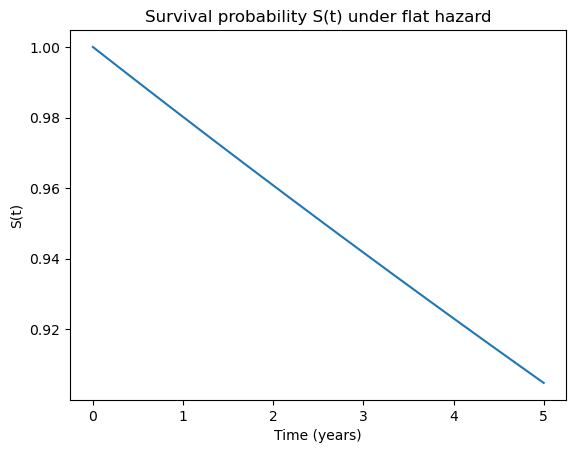

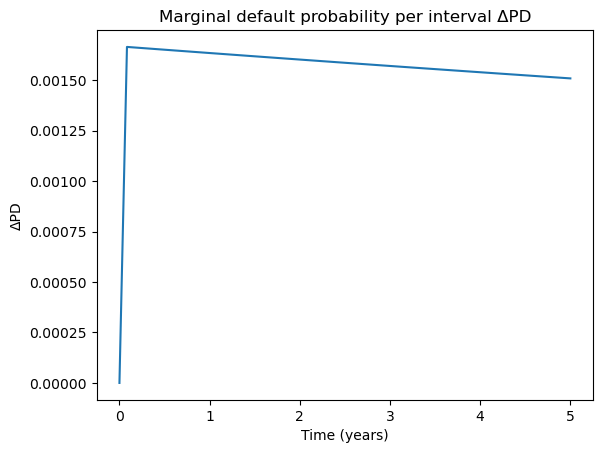

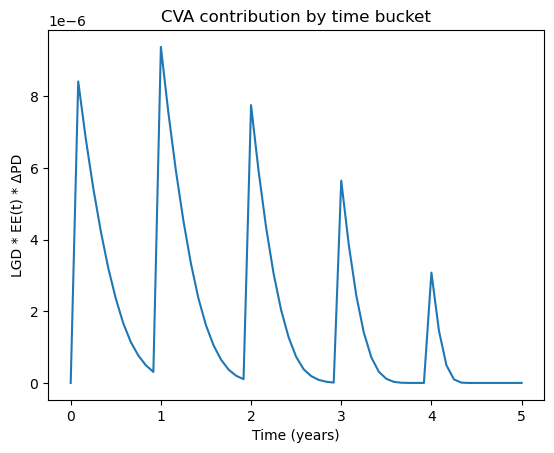

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- CVA from EE(t) using a flat hazard rate model ---

# Recovery assumption (typical unsecured senior is ~40% as a baseline)
recovery = 0.40
LGD = 1.0 - recovery

# Flat hazard rate (annualized). Example: 2% hazard ~ "moderate" credit risk.
# You can change this to see sensitivity.
hazard = 0.02

# eval_times_years: times corresponding to EE array (we already computed this)
t = eval_times_years  # alias for readability

# Survival probability at each evaluation time under flat hazard
S = np.exp(-hazard * t)

# Marginal default probability in each interval:
# ΔPD_k = P(default between t_{k-1} and t_k) = S(t_{k-1}) - S(t_k)
dPD = np.zeros_like(t)
dPD[1:] = S[:-1] - S[1:]

# CVA as LGD * sum( EE(t_k) * ΔPD_k )
CVA = LGD * np.sum(EE * dPD)

print("Assumptions:")
print("  recovery:", recovery, " LGD:", LGD)
print("  hazard rate:", hazard)
print("Results:")
print("  CVA (units of notional):", CVA)

# --- Plot the pieces so you can see what's driving CVA ---
plt.figure()
plt.plot(t, S)
plt.title("Survival probability S(t) under flat hazard")
plt.xlabel("Time (years)")
plt.ylabel("S(t)")
plt.show()

plt.figure()
plt.plot(t, dPD)
plt.title("Marginal default probability per interval ΔPD")
plt.xlabel("Time (years)")
plt.ylabel("ΔPD")
plt.show()

# Contribution to CVA by time bucket
cva_contrib = LGD * EE * dPD

plt.figure()
plt.plot(t, cva_contrib)
plt.title("CVA contribution by time bucket")
plt.xlabel("Time (years)")
plt.ylabel("LGD * EE(t) * ΔPD")
plt.show()



Discounted CVA (units of notional): 0.00011066346132282439
Undiscounted CVA: 0.00011737029092064316
Ratio (disc/undisc): 0.9428575191795902


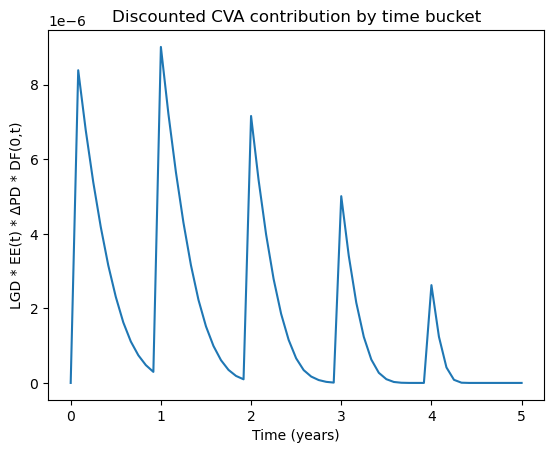

In [16]:
# --- Discounted CVA (more realistic) ---
# Loss happens at future time t_k, so discount the expected loss back to today.
# We'll use the average discount factor across Monte Carlo paths at each time bucket.

recovery = 0.40
LGD = 1.0 - recovery
hazard = 0.02

t = eval_times_years

# Survival under flat hazard
S = np.exp(-hazard * t)

# Marginal default prob per bucket
dPD = np.zeros_like(t)
dPD[1:] = S[:-1] - S[1:]

# Market discount factor per bucket: average across paths
# (df_paths is DF(0,t) pathwise on the same time grid; eval_indices picks the buckets)
DF_bucket = df_paths[:, eval_indices].mean(axis=0)

# Discounted CVA
CVA_disc = LGD * np.sum(EE * dPD * DF_bucket)

print("Discounted CVA (units of notional):", CVA_disc)

# Compare to your undiscounted CVA from before, if you kept it in variable CVA
try:
    print("Undiscounted CVA:", CVA)
    print("Ratio (disc/undisc):", CVA_disc / CVA)
except NameError:
    pass

# Plot contributions with discounting
cva_contrib_disc = LGD * EE * dPD * DF_bucket

plt.figure()
plt.plot(t, cva_contrib_disc)
plt.title("Discounted CVA contribution by time bucket")
plt.xlabel("Time (years)")
plt.ylabel("LGD * EE(t) * ΔPD * DF(0,t)")
plt.show()



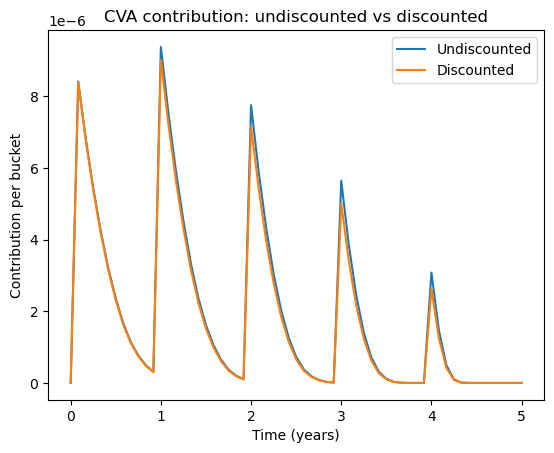

In [17]:
#overlay to see the difference between discount and no discount

cva_contrib_undisc = LGD * EE * dPD
cva_contrib_disc = LGD * EE * dPD * DF_bucket

plt.figure()
plt.plot(t, cva_contrib_undisc, label="Undiscounted")
plt.plot(t, cva_contrib_disc, label="Discounted")
plt.title("CVA contribution: undiscounted vs discounted")
plt.xlabel("Time (years)")
plt.ylabel("Contribution per bucket")
plt.legend()
plt.show()


CDS inputs (bps): [ 80.  95. 110. 125. 140.]
Implied hazard nodes: [0.01333333 0.01583333 0.01833333 0.02083333 0.02333333]
Discounted CVA with term hazard curve: 8.881302816331272e-05


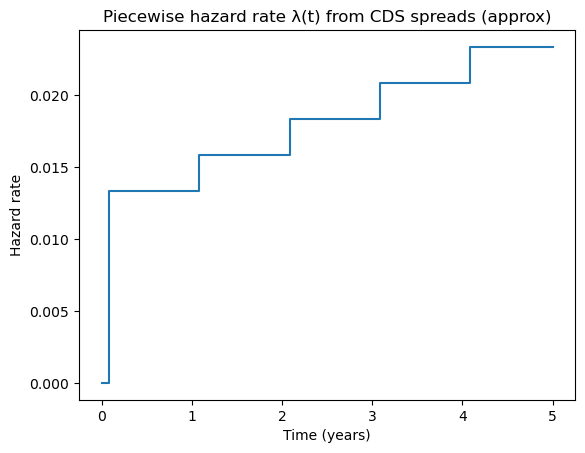

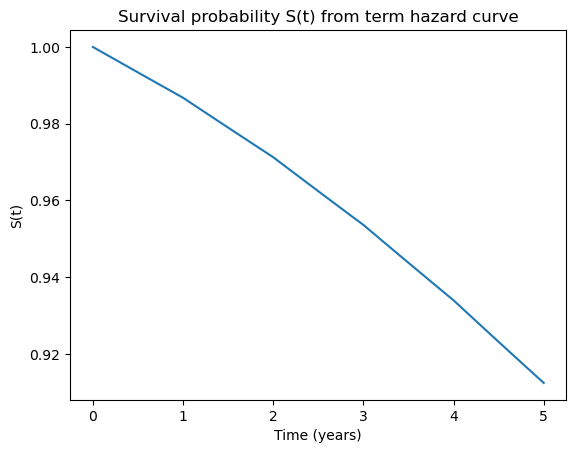

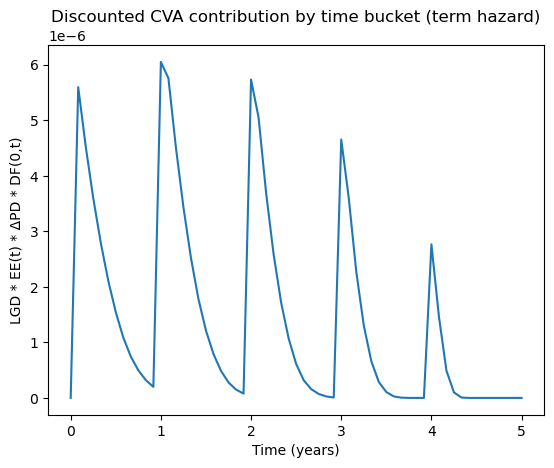

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# --- Term structure of hazard rates (piecewise) from CDS spread quotes ---

# 1) Credit assumptions
recovery = 0.40
LGD = 1.0 - recovery

# 2) Example CDS spreads by maturity (replace with real quotes later)
# Units: basis points per year
cds_maturities = np.array([1, 2, 3, 4, 5], dtype=float)          # years
cds_spreads_bps = np.array([80, 95, 110, 125, 140], dtype=float) # bps

# Convert bps to decimal per year (e.g., 80 bps -> 0.0080)
cds_spreads = cds_spreads_bps / 10000.0

# 3) Approx hazard in each maturity bucket: lambda ~ spread / LGD
# We make it piecewise-constant between quoted maturities.
hazard_nodes = cds_spreads / LGD  # annualized hazard rate at each maturity node

# 4) Build a piecewise-constant hazard function on your eval time grid
t = eval_times_years  # times for EE buckets

hazard_t = np.zeros_like(t)

# For t in (0, T1], use hazard_nodes[0]
# For t in (T1, T2], use hazard_nodes[1], etc.
for i, T in enumerate(cds_maturities):
    if i == 0:
        hazard_t[(t > 0) & (t <= T)] = hazard_nodes[i]
    else:
        hazard_t[(t > cds_maturities[i-1]) & (t <= T)] = hazard_nodes[i]

# If eval grid extends beyond last maturity, hold last hazard flat
hazard_t[t > cds_maturities[-1]] = hazard_nodes[-1]

# 5) Convert hazard term structure into survival probabilities
# Survival S(t) = exp(- integral_0^t lambda(u) du)
# We approximate the integral on the eval grid using cumulative sum.
dt_eval = np.diff(t, prepend=0.0)
cum_int = np.cumsum(hazard_t * dt_eval)
S_term = np.exp(-cum_int)

# 6) Default probability per bucket: ΔPD_k = S(t_{k-1}) - S(t_k)
dPD_term = np.zeros_like(t)
dPD_term[1:] = S_term[:-1] - S_term[1:]

# 7) Discounted CVA with term structure
DF_bucket = df_paths[:, eval_indices].mean(axis=0)  # DF(0,t_k) from your Monte Carlo
CVA_term = LGD * np.sum(EE * dPD_term * DF_bucket)

print("CDS inputs (bps):", cds_spreads_bps)
print("Implied hazard nodes:", hazard_nodes)
print("Discounted CVA with term hazard curve:", CVA_term)

# --- Diagnostics plots ---
plt.figure()
plt.step(t, hazard_t, where="post")
plt.title("Piecewise hazard rate λ(t) from CDS spreads (approx)")
plt.xlabel("Time (years)")
plt.ylabel("Hazard rate")
plt.show()

plt.figure()
plt.plot(t, S_term)
plt.title("Survival probability S(t) from term hazard curve")
plt.xlabel("Time (years)")
plt.ylabel("S(t)")
plt.show()

cva_contrib_term = LGD * EE * dPD_term * DF_bucket

plt.figure()
plt.plot(t, cva_contrib_term)
plt.title("Discounted CVA contribution by time bucket (term hazard)")
plt.xlabel("Time (years)")
plt.ylabel("LGD * EE(t) * ΔPD * DF(0,t)")
plt.show()


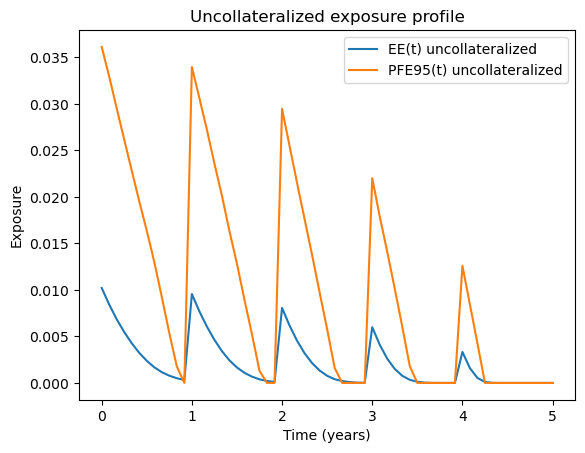

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- Build PV(t) across paths and evaluation times (store it) ---

notional = 1.0
fixed_rate = 0.04
fixed_cashflow = notional * fixed_rate

payment_times_years = np.arange(1, years + 1)
payment_indices = (payment_times_years / dt).astype(int)

eval_step = 21  # ~monthly evaluation grid
eval_indices = np.arange(0, n_steps + 1, eval_step)
eval_times_years = eval_indices * dt

# Store swap PV for every (time bucket, path)
# V[k, i] = swap PV at eval time k for path i
V = np.zeros((len(eval_indices), n_paths))

# Also store uncollateralized exposure stats (for comparison)
EE = np.zeros(len(eval_indices))
PFE95 = np.zeros(len(eval_indices))

for k, t_idx in enumerate(eval_indices):
    df_0_t = df_paths[:, t_idx]

    # Floating leg PV at time t (par floater approximation)
    df_t_T = df_paths[:, -1] / df_0_t
    pv_float_t = notional * (1.0 - df_t_T)

    # Fixed leg PV at time t (remaining fixed payments only)
    pv_fixed_t = np.zeros(n_paths)
    for pay_idx in payment_indices:
        if pay_idx > t_idx:
            df_t_pay = df_paths[:, pay_idx] / df_0_t
            pv_fixed_t += fixed_cashflow * df_t_pay

    # Swap PV at time t (pay fixed, receive float)
    pv_swap_t = pv_float_t - pv_fixed_t

    # Save PV(t) by path for collateral modeling later
    V[k, :] = pv_swap_t

    # Uncollateralized exposure stats (baseline)
    exposure_t = np.maximum(pv_swap_t, 0.0)
    EE[k] = exposure_t.mean()
    PFE95[k] = np.percentile(exposure_t, 95)

plt.figure()
plt.plot(eval_times_years, EE, label="EE(t) uncollateralized")
plt.plot(eval_times_years, PFE95, label="PFE95(t) uncollateralized")
plt.title("Uncollateralized exposure profile")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")
plt.legend()
plt.show()


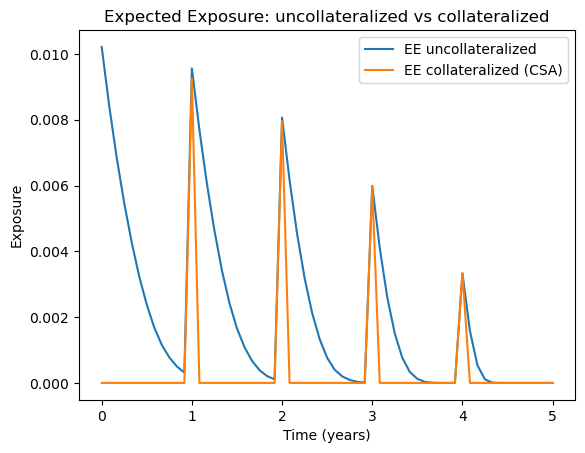

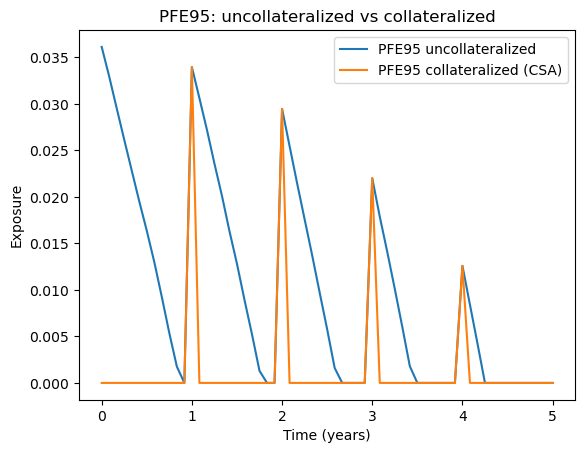

MPOR buckets: 1
EE(0) uncoll: 0.010214865743509556 EE(0) coll: 0.0
EE(end) uncoll: 0.0 EE(end) coll: 0.0


In [20]:
# --- CSA collateral model (simple) ---

# CSA parameters (edit these to see effects)
TH = 0.00      # threshold (in notional units). 0 means "fully collateralized"
MTA = 0.00     # minimum transfer amount
MPOR_days = 10 # margin period of risk (typical 10 business days)

# Convert MPOR in days to number of eval buckets
# eval_step is in business days, so MPOR_buckets is roughly MPOR_days / eval_step
MPOR_buckets = int(np.ceil(MPOR_days / eval_step))

# Collateral posted by counterparty to us at time k (per path)
# We model collateral as if it is set based on value MPOR_buckets ago (stale collateral).
C = np.zeros_like(V)

for k in range(len(eval_indices)):
    # Collateral call time index (stale by MPOR)
    k_call = max(k - MPOR_buckets, 0)

    # "Unsecured amount" at call time: max(V - TH, 0)
    unsecured_call = np.maximum(V[k_call, :] - TH, 0.0)

    # Apply MTA: if unsecured amount is below MTA, do not transfer
    collateral_call = np.where(unsecured_call >= MTA, unsecured_call, 0.0)

    # Collateral held at time k is what was called at time k_call
    C[k, :] = collateral_call

# Collateralized exposure: max(V - C, 0)
E_coll = np.maximum(V - C, 0.0)

EE_coll = E_coll.mean(axis=1)
PFE95_coll = np.percentile(E_coll, 95, axis=1)

plt.figure()
plt.plot(eval_times_years, EE, label="EE uncollateralized")
plt.plot(eval_times_years, EE_coll, label="EE collateralized (CSA)")
plt.title("Expected Exposure: uncollateralized vs collateralized")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")
plt.legend()
plt.show()

plt.figure()
plt.plot(eval_times_years, PFE95, label="PFE95 uncollateralized")
plt.plot(eval_times_years, PFE95_coll, label="PFE95 collateralized (CSA)")
plt.title("PFE95: uncollateralized vs collateralized")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")
plt.legend()
plt.show()

print("MPOR buckets:", MPOR_buckets)
print("EE(0) uncoll:", EE[0], "EE(0) coll:", EE_coll[0])
print("EE(end) uncoll:", EE[-1], "EE(end) coll:", EE_coll[-1])


In [21]:
# --- Discounted CVA using collateralized EE(t) ---

recovery = 0.40
LGD = 1.0 - recovery

# Use your term hazard curve if you have it; otherwise set flat hazard
# If you already created dPD_term earlier, use it. If not, create a flat hazard dPD.
try:
    dPD_used = dPD_term
    print("Using term hazard curve for dPD.")
except NameError:
    hazard = 0.02
    S = np.exp(-hazard * eval_times_years)
    dPD_used = np.zeros_like(eval_times_years)
    dPD_used[1:] = S[:-1] - S[1:]
    print("Using flat hazard rate for dPD:", hazard)

# Discount factors at the evaluation buckets (market DF)
DF_bucket = df_paths[:, eval_indices].mean(axis=0)

CVA_uncoll = LGD * np.sum(EE * dPD_used * DF_bucket)
CVA_coll = LGD * np.sum(EE_coll * dPD_used * DF_bucket)

print("Discounted CVA uncollateralized:", CVA_uncoll)
print("Discounted CVA collateralized:", CVA_coll)
print("Reduction factor (coll/uncoll):", CVA_coll / CVA_uncoll)


Using term hazard curve for dPD.
Discounted CVA uncollateralized: 8.881302816331272e-05
Discounted CVA collateralized: 1.890852798093714e-05
Reduction factor (coll/uncoll): 0.21290263795720862
